# 02 - Modelo Inicial
Repositorio: [github.com/MateoRomano02/tp_equidad](https://github.com/MateoRomano02/tp_equidad)


Este notebook corresponde al punto N°2 y N°3 del TP

## Objetivo
Entrenar un modelo de clasificación sobre el dataset *German Credit Data* y evaluar su rendimiento con métricas como accuracy, precision, recall y F1-score. Además, se analizará cuál error es más costoso para el banco.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

## Carga de datos

In [2]:

df = pd.read_csv("..\data\processed\south_german_credit_clean.csv")

df.head()


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,other_debtors,present_residence,...,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,target,sex,personal_status
0,no checking account,9,all credits at this bank paid back duly,others,2799,unknown/no savings account,1 <= ... < 4 yrs,25 <= ... < 35,none,1 <= ... < 4 yrs,...,none,for free,2-3,skilled employee/official,3 or more,no,no,good,male,non-single
1,no checking account,12,all credits at this bank paid back duly,others,2122,unknown/no savings account,1 <= ... < 4 yrs,20 <= ... < 25,none,1 <= ... < 4 yrs,...,none,for free,2-3,unskilled - resident,3 or more,no,yes,good,male,non-single
2,no checking account,12,all credits at this bank paid back duly,others,2171,unknown/no savings account,1 <= ... < 4 yrs,< 20,none,>= 7 yrs,...,bank,rent,2-3,unskilled - resident,0 to 2,no,yes,good,male,non-single
3,no checking account,10,all credits at this bank paid back duly,others,2241,unknown/no savings account,< 1 yr,>= 35,none,4 <= ... < 7 yrs,...,none,for free,2-3,unskilled - resident,3 or more,no,yes,good,male,non-single
4,no checking account,8,all credits at this bank paid back duly,others,3398,unknown/no savings account,4 <= ... < 7 yrs,>= 35,none,>= 7 yrs,...,none,rent,2-3,unskilled - resident,0 to 2,no,yes,good,male,non-single


## Modelo

Vamos a entrenar un *Árbol de Decisión* porque es fácil de entender y nos parece adecuado para un primer modelo.

Por el desbalance de clases, conviene usar SMOTE y de paso podemos armar un pipeline para buscar buenos parámetros con Grid Search y validación cruzada.

In [ ]:
# Separar features y target
X = df.drop(columns=["target"])
y = df["target"].map({"good": 1, "bad": 0})  # good = positivo (1), bad = negativo (0)

# Codificar variables categóricas
X = pd.get_dummies(X, drop_first=True)

# Dividir en train/test (30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Pipeline con SMOTE + Árbol + GridSearch
pipeline = ImbPipeline([
    ("smote", SMOTE(random_state=42)),
    ("scaler", StandardScaler()),  # No estrictamente necesario para árboles, pero se incluye por buenas prácticas
    ("clf", DecisionTreeClassifier(random_state=42))
])

# Definir los hiperparámetros a buscar
param_grid = {
    "clf__max_depth": [3, 5, 10, None],
    "clf__min_samples_split": [2, 5, 10],
    "clf__min_samples_leaf": [1, 2, 5],
    "clf__criterion": ["gini", "entropy"]
}

# GridSearch con validación cruzada
grid_search = GridSearchCV(
    pipeline, param_grid, scoring="f1", cv=5, n_jobs=-1
)
grid_search.fit(X_train, y_train)

# Predicciones
y_pred = grid_search.predict(X_test)

# Métricas
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=["bad (0)", "good (1)"])
best_params = grid_search.best_params_

=== Métricas del Modelo ===

Distribución de clases en el dataset original:
target
good    700
bad     300
Name: count, dtype: int64 

Mejores hiperparámetros encontrados por GridSearch:
  clf__criterion: gini
  clf__max_depth: 10
  clf__min_samples_leaf: 5
  clf__min_samples_split: 2

Reporte de clasificación en test:
              precision    recall  f1-score   support

     bad (0)       0.45      0.49      0.47        90
    good (1)       0.77      0.74      0.76       210

    accuracy                           0.67       300
   macro avg       0.61      0.62      0.61       300
weighted avg       0.68      0.67      0.67       300



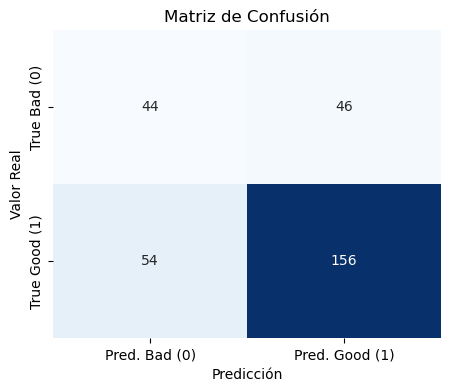

In [34]:
# print de las métrcias
print("=== Métricas del Modelo ===\n")
print("Distribución de clases en el dataset original:")
print(class_distribution, "\n")

print("Mejores hiperparámetros encontrados por GridSearch:")
for k, v in best_params.items():
    print(f"  {k}: {v}")
print("\nReporte de clasificación en test:")
print(class_report)

# Plot de la matriz de confusión
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred. Bad (0)", "Pred. Good (1)"],
            yticklabels=["True Bad (0)", "True Good (1)"])
plt.title("Matriz de Confusión")
plt.ylabel("Valor Real")
plt.xlabel("Predicción")
plt.show()

## Análisis de errores y trade-off

En el contexto bancario, donde el objetivo es **maximizar los préstamos otorgados a personas que efectivamente los van a pagar**, el **falso positivo** (darle un préstamo a alguien que no lo va a pagar) puede representar una **pérdida financiera** significativa.

En cambio, un **falso negativo** (negarle un préstamo a alguien que sí lo iba a pagar) implica una oportunidad perdida, pero no un costo directo. Por eso, **los falsos positivos son el error más costoso** en este escenario.

Esto debería reflejarse en el umbral de decisión y posiblemente en la elección de métricas (por ejemplo, priorizar un FPR bajo).


# 03 - Evaluación de equidad del modelo inicial


## Descripcion de las metricas de fairness vistas en clase para este contexto

1)Statistical Parity:
La proporcion de creditos aprobados de ambos grupos analizados debe ser estar dentro de nuestro criterio de comparacion.
Independientemente de la proporcion de buenos pagadores en ambos grupos, la prediccion positiva deberia ser la misma.

2)Equalized Odds:
La tasa de TPR y FPR debe ser la misma en ambos grupos.Es decir que el modelo se equivoca y acierta en la misma proporcion para ambos grupos, con respecto a la aprobacion
de creditos en ambos grupos.

3)Equal Opportunity:
El modelo se asegura de que en solo el caso de quienes si pagarian el prestamo, sea igual la proporcion de aprobados crediticiamente para los dos grupos.

4)Predictive Parity:
Se busca que la calidad de aprobaciones sea equitativa para ambos grupos.

## Analisis de fairness en el modelo anterior

 El umbral que nosotros proponemos para la diferencia del modulo entre las metricas de ambos grupos es el del 0.08 (8%)

## Obtencion de las metricas

In [ ]:
# Unimos X_test con y_test y y_pred
df_eval = X_test.copy()
df_eval["y_true"] = y_test
df_eval["y_pred"] = y_pred


# Filtrar por género
male_df = df_eval[df_eval["sex_male"] == True]
female_df = df_eval[df_eval["sex_male"] == False]

def compute_metrics(df_group):
    y_true = df_group["y_true"]
    y_pred = df_group["y_pred"]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()

    # Fairness metrics
    sp = np.mean(y_pred)                         # Statistical Parity: P(Ŷ=1)
    pp = tp / (tp + fp) if (tp + fp) > 0 else 0  # Predictive Parity: P(Y=1|Ŷ=1)
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 # Equal Opportunity: P(Ŷ=1|Y=1)
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0 # False Positive Rate: P(Ŷ=1|Y=0)
    
    return sp, pp, tpr, fpr

sp_male, pp_male, tpr_male, fpr_male = compute_metrics(male_df)
sp_female, pp_female, tpr_female, fpr_female = compute_metrics(female_df)

## Comparacion entre ambos grupos

In [33]:
print("{:<25} {:<15} {:<15} {:<15}".format("Métrica", "Masculino", "Femenino", "Diferencia (Fem - Masc)"))
print("-" * 70)
print("{:<25} {:<15.3f} {:<15.3f} {:<15.3f}".format("Statistical Parity", sp_male, sp_female, sp_female - sp_male))
print("{:<25} {:<15.3f} {:<15.3f} {:<15.3f}".format("Predictive Parity", pp_male, pp_female, pp_female - pp_male))
print("{:<25} {:<15.3f} {:<15.3f} {:<15.3f}".format("TPR (Equal Opportunity)", tpr_male, tpr_female, tpr_female - tpr_male))
print("{:<25} {:<15.3f} {:<15.3f} {:<15.3f}".format("FPR", fpr_male, fpr_female, fpr_female - fpr_male))

Métrica                   Masculino       Femenino        Diferencia (Fem - Masc)
----------------------------------------------------------------------
Statistical Parity        0.671           0.689           0.018          
Predictive Parity         0.772           0.774           0.002          
TPR (Equal Opportunity)   0.729           0.828           0.098          
FPR                       0.527           0.438           -0.090         


## Conclusiones de los resultados de las metricas

Cumple `Statistical Parity`, `Predictive Parity`, pero tiene una diferencia de `FPR` alta y no cumple `Equal Opportunity` (por ende tampoco `Equalized Odds`)

## Eleccion del criterio de fairness

Nosotros elegimos el criterio de `Equalized Odds`.

Debido a que como personal del banco tenemos que encontrar un balance que no perjudique a los clientes pero tampoco a nuestra institucion.
Asi que los clientes que si pagaran son aprobados en las mismas probabilidades entre hombres y mujeres.


Mientras que los que no pagarian, son rechazados en la misma probabilidad para los dos grupos.
El aumento del FPR en mujeres podria ser un riesgo para el banco por lo que esta medida, haria el modelo mas confiable desde una perspectiva bancaria.